In [96]:
import pickle
from IPython.display import Image, display

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
sys.path.insert(0, "../..")
from models.model import build_model

In [97]:
plt.rcParams["figure.dpi"] = 200

In [98]:
IMAGE_SIZE = (224, 224)
COLOR_MODE = "rgb"

## Test

In [99]:
MODEL_PATH = "../../models/checkpoints/20230618"

In [100]:
# Open model for getting prediction.
input_shape = (224, 224, 3)
with open(f"{MODEL_PATH}/labels", "rb") as fp:
    labels = pickle.load(fp)
trained_model = build_model(num_classes=len(labels), input_shape=input_shape)
trained_model.load_weights(f"{MODEL_PATH}/weights.h5")

In [102]:
# Define path to an image to test.
path_image_test = "example.jpg"

In [103]:
img = keras.preprocessing.image.load_img(path_image_test, target_size = IMAGE_SIZE, color_mode = COLOR_MODE)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

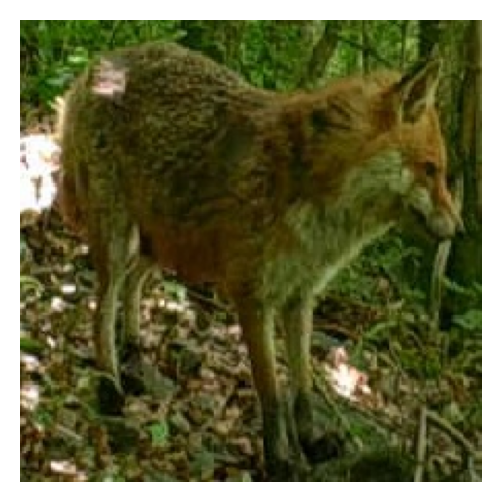

In [104]:
plt.figure(figsize = (3, 3))
plt.imshow(img_array.numpy().squeeze().astype("uint8"))
plt.axis("off");

In [105]:
predictions = trained_model.predict(img_array)

In [106]:
np.round(predictions, 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [107]:
np.array(labels)[np.argmax(predictions[0])]

'fox'

In [108]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    # First, we create a model that maps the input image to the activations.
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [109]:
# Remove last layer's softmax.
trained_model.layers[-1].activation = None

In [110]:
# Generate class activation heatmap.
heatmap = make_gradcam_heatmap(img_array, trained_model, last_conv_layer_name = "top_conv")

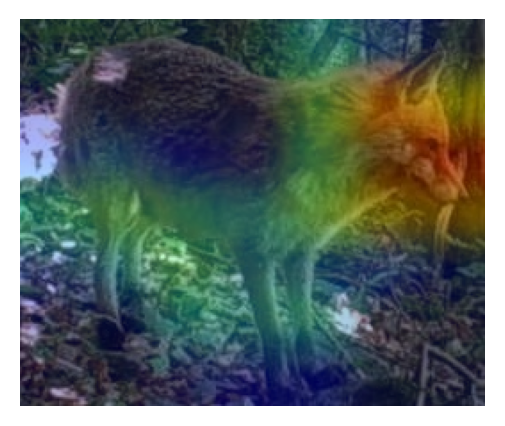

In [111]:
def display_gradcam(img_path, heatmap, alpha = 0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img) 
    
    # Rescale heatmap to a range 0-255.
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap.
    jet = plt.colormaps.get_cmap("jet")

    # Use RGB values of the colormap.
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap.
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image.
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM.
    plt.figure(figsize = (3, 3))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()
    
display_gradcam(path_image_test, heatmap)